In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import skimage
from numba import jit
from modules.process import Process
from modules.edge import get_bright_edge
from modules.mass_center import compute_mass_center
from modules.bright2dark import get_b2d_data
from modules.dense_area import get_dense_area
from modules.grouping import divideIntoGroups, count_label_sizes
from modules.helper import display_images, display_stats
from modules.fft import lowpass_filter
from modules.fitting import fit2circle, fit2circle_points, fit_points_to_circle_iteration, cross_circle_and_labels
from modules.mask import to_mask, get_dilated_mask
from modules.contour import get_largest_brightness_diff_contour_id, select_concentric_contour_indices
from config import base_dir

In [ ]:
path = '/mnt/c/Users/hiran/Documents/Research/Experiment_data/Droplet/20240209/20240209_3-branch_Y3-3x5_deg55_wu_exp100ms_ph2_take1_cropped.tif'
instance = Process(path)

dust_mask = np.zeros(instance.gray_images[0].shape)
cv2.circle(dust_mask, (100, 148), 16, color=1, thickness=-1)
cv2.circle(dust_mask, (523, 305), 13, color=1, thickness=-1)
cv2.circle(dust_mask, (450, 483), 11, color=1, thickness=-1)
instance.dust_mask = dust_mask

# 液滴を円で近似する
index 60以降は、境界が不明瞭であるため、うまく近似するには時間的連続性を考慮する必要あり。（未実装）

In [ ]:
def get_noise_suppressed_b2d_vector_image(b2d_vector_image, b2d_cos_image, dust_mask):
    dst = b2d_vector_image.copy()
    dst[dust_mask == 1] = 0
    dst[b2d_cos_image < 0.3] = 0
    dst = cv2.GaussianBlur(dst, (11, 11), sigmaX=0, sigmaY=0)
    thresh = np.mean(dst) + np.std(dst) * 2
    dst[dst < thresh] = 0
    return dst

def get_large_label_indices(nlabels, labels, debug_mode=False):
    label_sizes = count_label_sizes(nlabels, labels)
    if debug_mode:
        plt.plot(label_sizes) # debug
        plt.plot([np.mean(label_sizes) + np.std(label_sizes)] * len(label_sizes), label='mean + 1 sigma')
        plt.ylabel('label size')
        plt.legend()
    thresh = min(1000, np.mean(label_sizes) + np.std(label_sizes))
    return np.where(label_sizes > thresh)[0]

#############################################################################

def test_run2(instance, index):
    gray = instance.gray_images[index]

    # mass center
    dilated_dust_mask = get_dilated_mask(instance.dust_mask)
    cx, cy = compute_mass_center(gray, dilated_dust_mask)

    # edge points
    edge = get_bright_edge(gray)
    edge[dilated_dust_mask == 1] = 0

    # b2d data
    blurred = cv2.GaussianBlur(gray, ksize=(7, 7), sigmaX=0, sigmaY=0)
    b2d_vector_image, b2d_cos_image = get_b2d_data(blurred, cx, cy, sobel_ksize=3)

    # ノイズ除去
    noise_suppressed = get_noise_suppressed_b2d_vector_image(b2d_vector_image, b2d_cos_image, instance.dust_mask)
    noise_suppressed[noise_suppressed > 0] = 1
    dilated = cv2.dilate(noise_suppressed.astype('uint8'), kernel=(5, 5))

    # 細かい領域は無視する
    nlabels, labels = cv2.connectedComponents(dilated.astype('uint8'))
    large_label_indices = get_large_label_indices(nlabels, labels, debug_mode=True)
    large_labels = np.zeros(labels.shape)
    for index in large_label_indices:
        large_labels[labels == index] = 1

    # 余分なlabelを排除する
    binary_image = np.zeros(large_labels.shape)
    binary_image[large_labels > 0] = 1
    arr_circle, arr_points = fit_points_to_circle_iteration(binary_image, itr=1)
    cv2.circle(large_labels, (int(arr_circle[0][0]), int(arr_circle[0][1])), int(arr_circle[0][2]), 2, 2)
    appropriate_label_indices = large_label_indices[_cross_circle_and_labels(labels, large_label_indices, arr_circle[0][0], arr_circle[0][1], arr_circle[0][2], w_in=5, w_out=50, thresh=0.1)]

    # 絞り込んだlabelたちを円近似
    binary_image = np.zeros(labels.shape)
    for label_id in appropriate_label_indices:
        binary_image[labels == label_id] = 1
    num_itr = 2
    arr_circle, arr_points = fit_points_to_circle_iteration(binary_image, w_out=5, itr=num_itr)

    # draw
    canvas = np.copy(gray)
    for i in range(num_itr):
        cx, cy, cr = map(int, arr_circle[i])
        cv2.circle(canvas, (cx, cy), cr, color=0, thickness=1+i)
    
    print('large label indices:', large_label_indices)
    images = [gray, edge, b2d_vector_image, b2d_cos_image, labels, large_labels, binary_image, canvas]
    names = ['gray', 'edge', 'b2d vector', 'b2d cos', 'labels', 'large_labels', 'appropriate labels', 'circle fitting']
    display_images(images, names, w=4)
    return images

def run2(instance):
    list_arr_circle = []
    list_arr_points = []
    for gray in instance.gray_images[:60]:
        # mass center
        dilated_dust_mask = get_dilated_mask(instance.dust_mask)
        cx, cy = compute_mass_center(gray, dilated_dust_mask)

        # edge points
        edge = get_bright_edge(gray)
        edge[dilated_dust_mask == 1] = 0

        # b2d data
        blurred = cv2.GaussianBlur(gray, ksize=(7, 7), sigmaX=0, sigmaY=0)
        b2d_vector_image, b2d_cos_image = get_b2d_data(blurred, cx, cy, sobel_ksize=3)

        # ノイズ除去
        noise_suppressed = get_noise_suppressed_b2d_vector_image(b2d_vector_image, b2d_cos_image, instance.dust_mask)
        noise_suppressed[noise_suppressed > 0] = 1
        dilated = cv2.dilate(noise_suppressed.astype('uint8'), kernel=(5, 5))

        # 細かい領域は無視する
        nlabels, labels = cv2.connectedComponents(dilated.astype('uint8'))
        large_label_indices = get_large_label_indices(nlabels, labels)
        large_labels = np.zeros(labels.shape)
        for index in large_label_indices:
            large_labels[labels == index] = 1

        # 余分なlabelを排除する
        binary_image = np.zeros(large_labels.shape)
        binary_image[large_labels > 0] = 1

        arr_circle, arr_points = fit_points_to_circle_iteration(binary_image, itr=1)
        appropriate_label_indices = large_label_indices[cross_circle_and_labels(labels, large_label_indices, arr_circle[0][0], arr_circle[0][1], arr_circle[0][2], w_in=5, w_out=50, thresh=0.1)]

        # 絞り込んだlabelたちを円近似
        binary_image = np.zeros(labels.shape)
        for label_id in appropriate_label_indices:
            binary_image[labels == label_id] = 1
        
        num_itr = 2
        arr_circle, arr_points = fit_points_to_circle_iteration(binary_image, w_out=5, itr=num_itr)

        list_arr_circle.append(arr_circle)
        list_arr_points.append(arr_points)
    
    return list_arr_circle, list_arr_points

In [ ]:
# test_run2(instance, 100)

In [ ]:
list_arr_circle, list_arr_points = run2(instance)

In [ ]:
plt.plot([arr_circle[0][2] for arr_circle in list_arr_circle], color='red')
plt.plot([arr_circle[1][2] for arr_circle in list_arr_circle], color='blue')
# plt.plot([arr_circle[1][2] / arr_circle[0][2] for arr_circle in list_arr_circle])

canvases = []
names = []
for i in range(5, 15):
    canvas = instance.gray_images[i].copy()
    cx, cy, cr = map(int, list_arr_circle[i][0])
    cv2.circle(canvas, (cx, cy), cr, 0, 1)
    cx, cy, cr = map(int, list_arr_circle[i][1])
    cv2.circle(canvas, (cx, cy), cr, 0, 3)
    canvases.append(instance.gray_images[i])
    canvases.append(canvas)
    names.append(f'gray {i}')
    names.append(f'circle {i}')

display_images(canvases, names, w=4)

# 突出しているかどうかの判定
界面に曲率が大きい部位が存在するかどうかで判定したい

large label indices: [ 4 28 48]


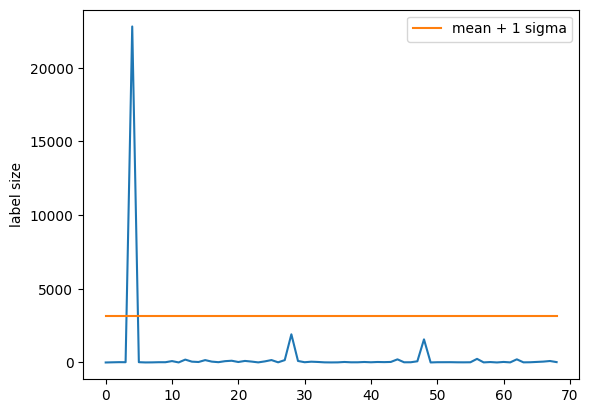

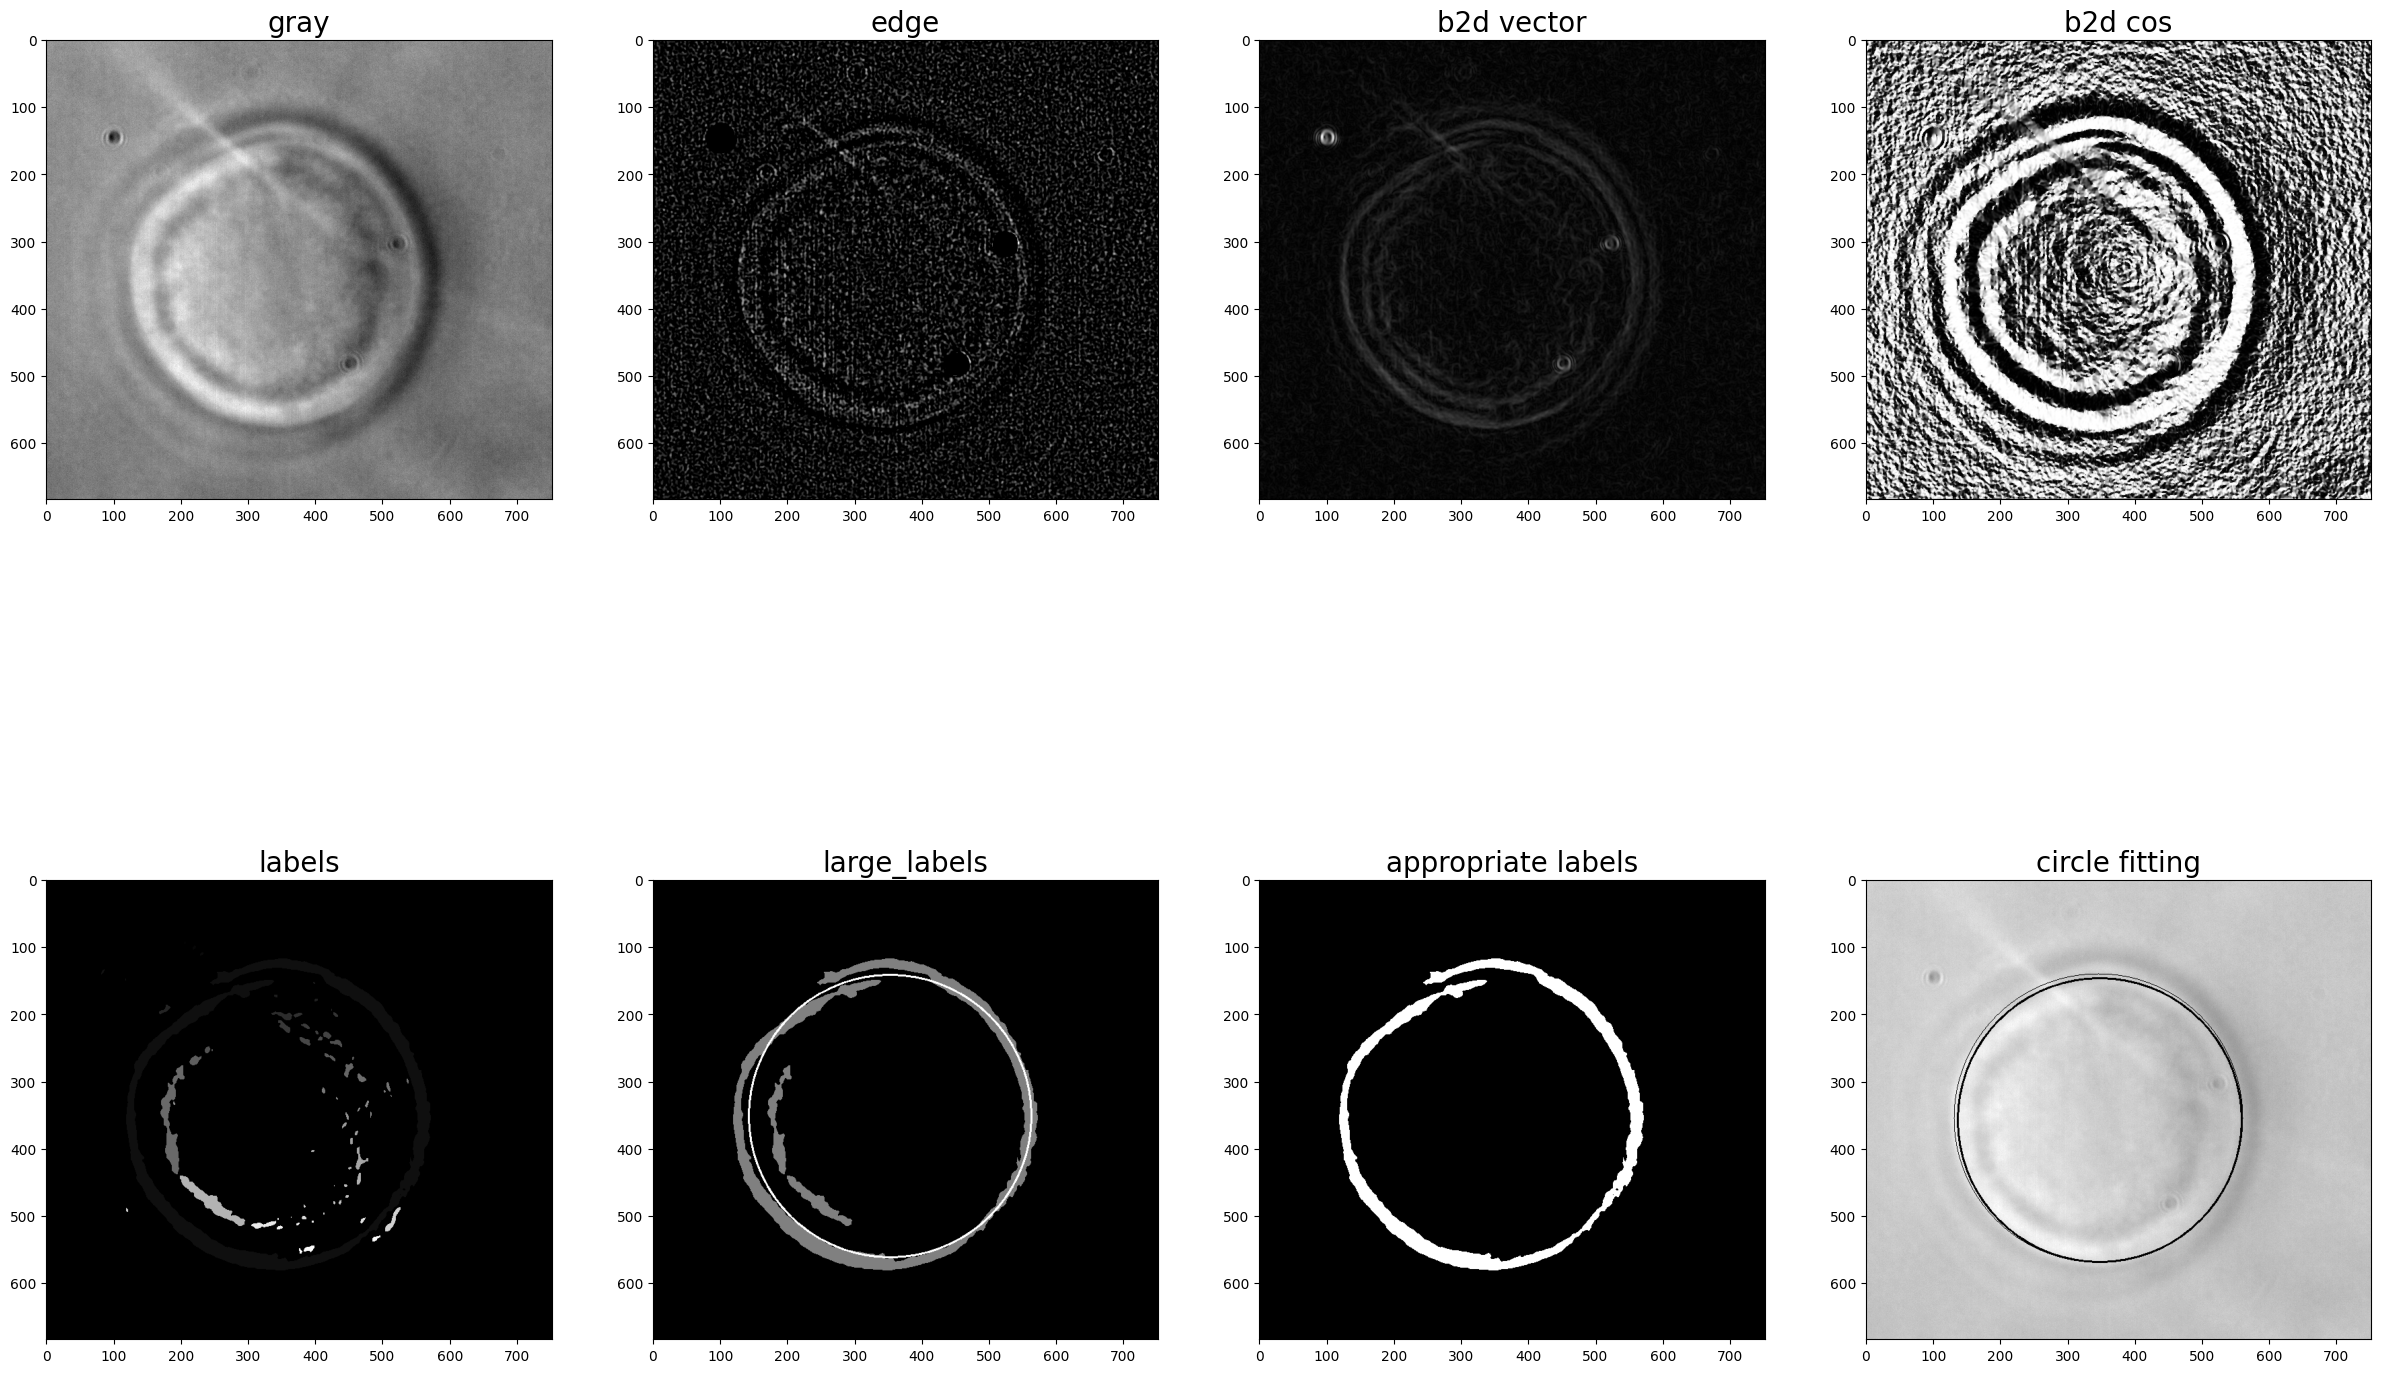

In [233]:
index = 28
gray, edge, b2d_vector_image, b2d_cos_image, labels, large_labels, appropriate_labels, canvas = test_run2(instance, index)

cx, cy, cr: 347.09967705440044 358.70451448335757 211.48192401475782


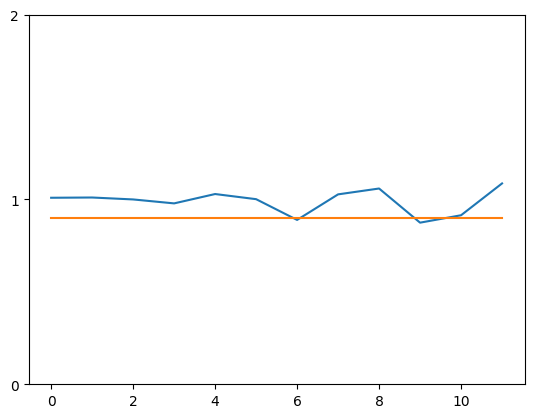

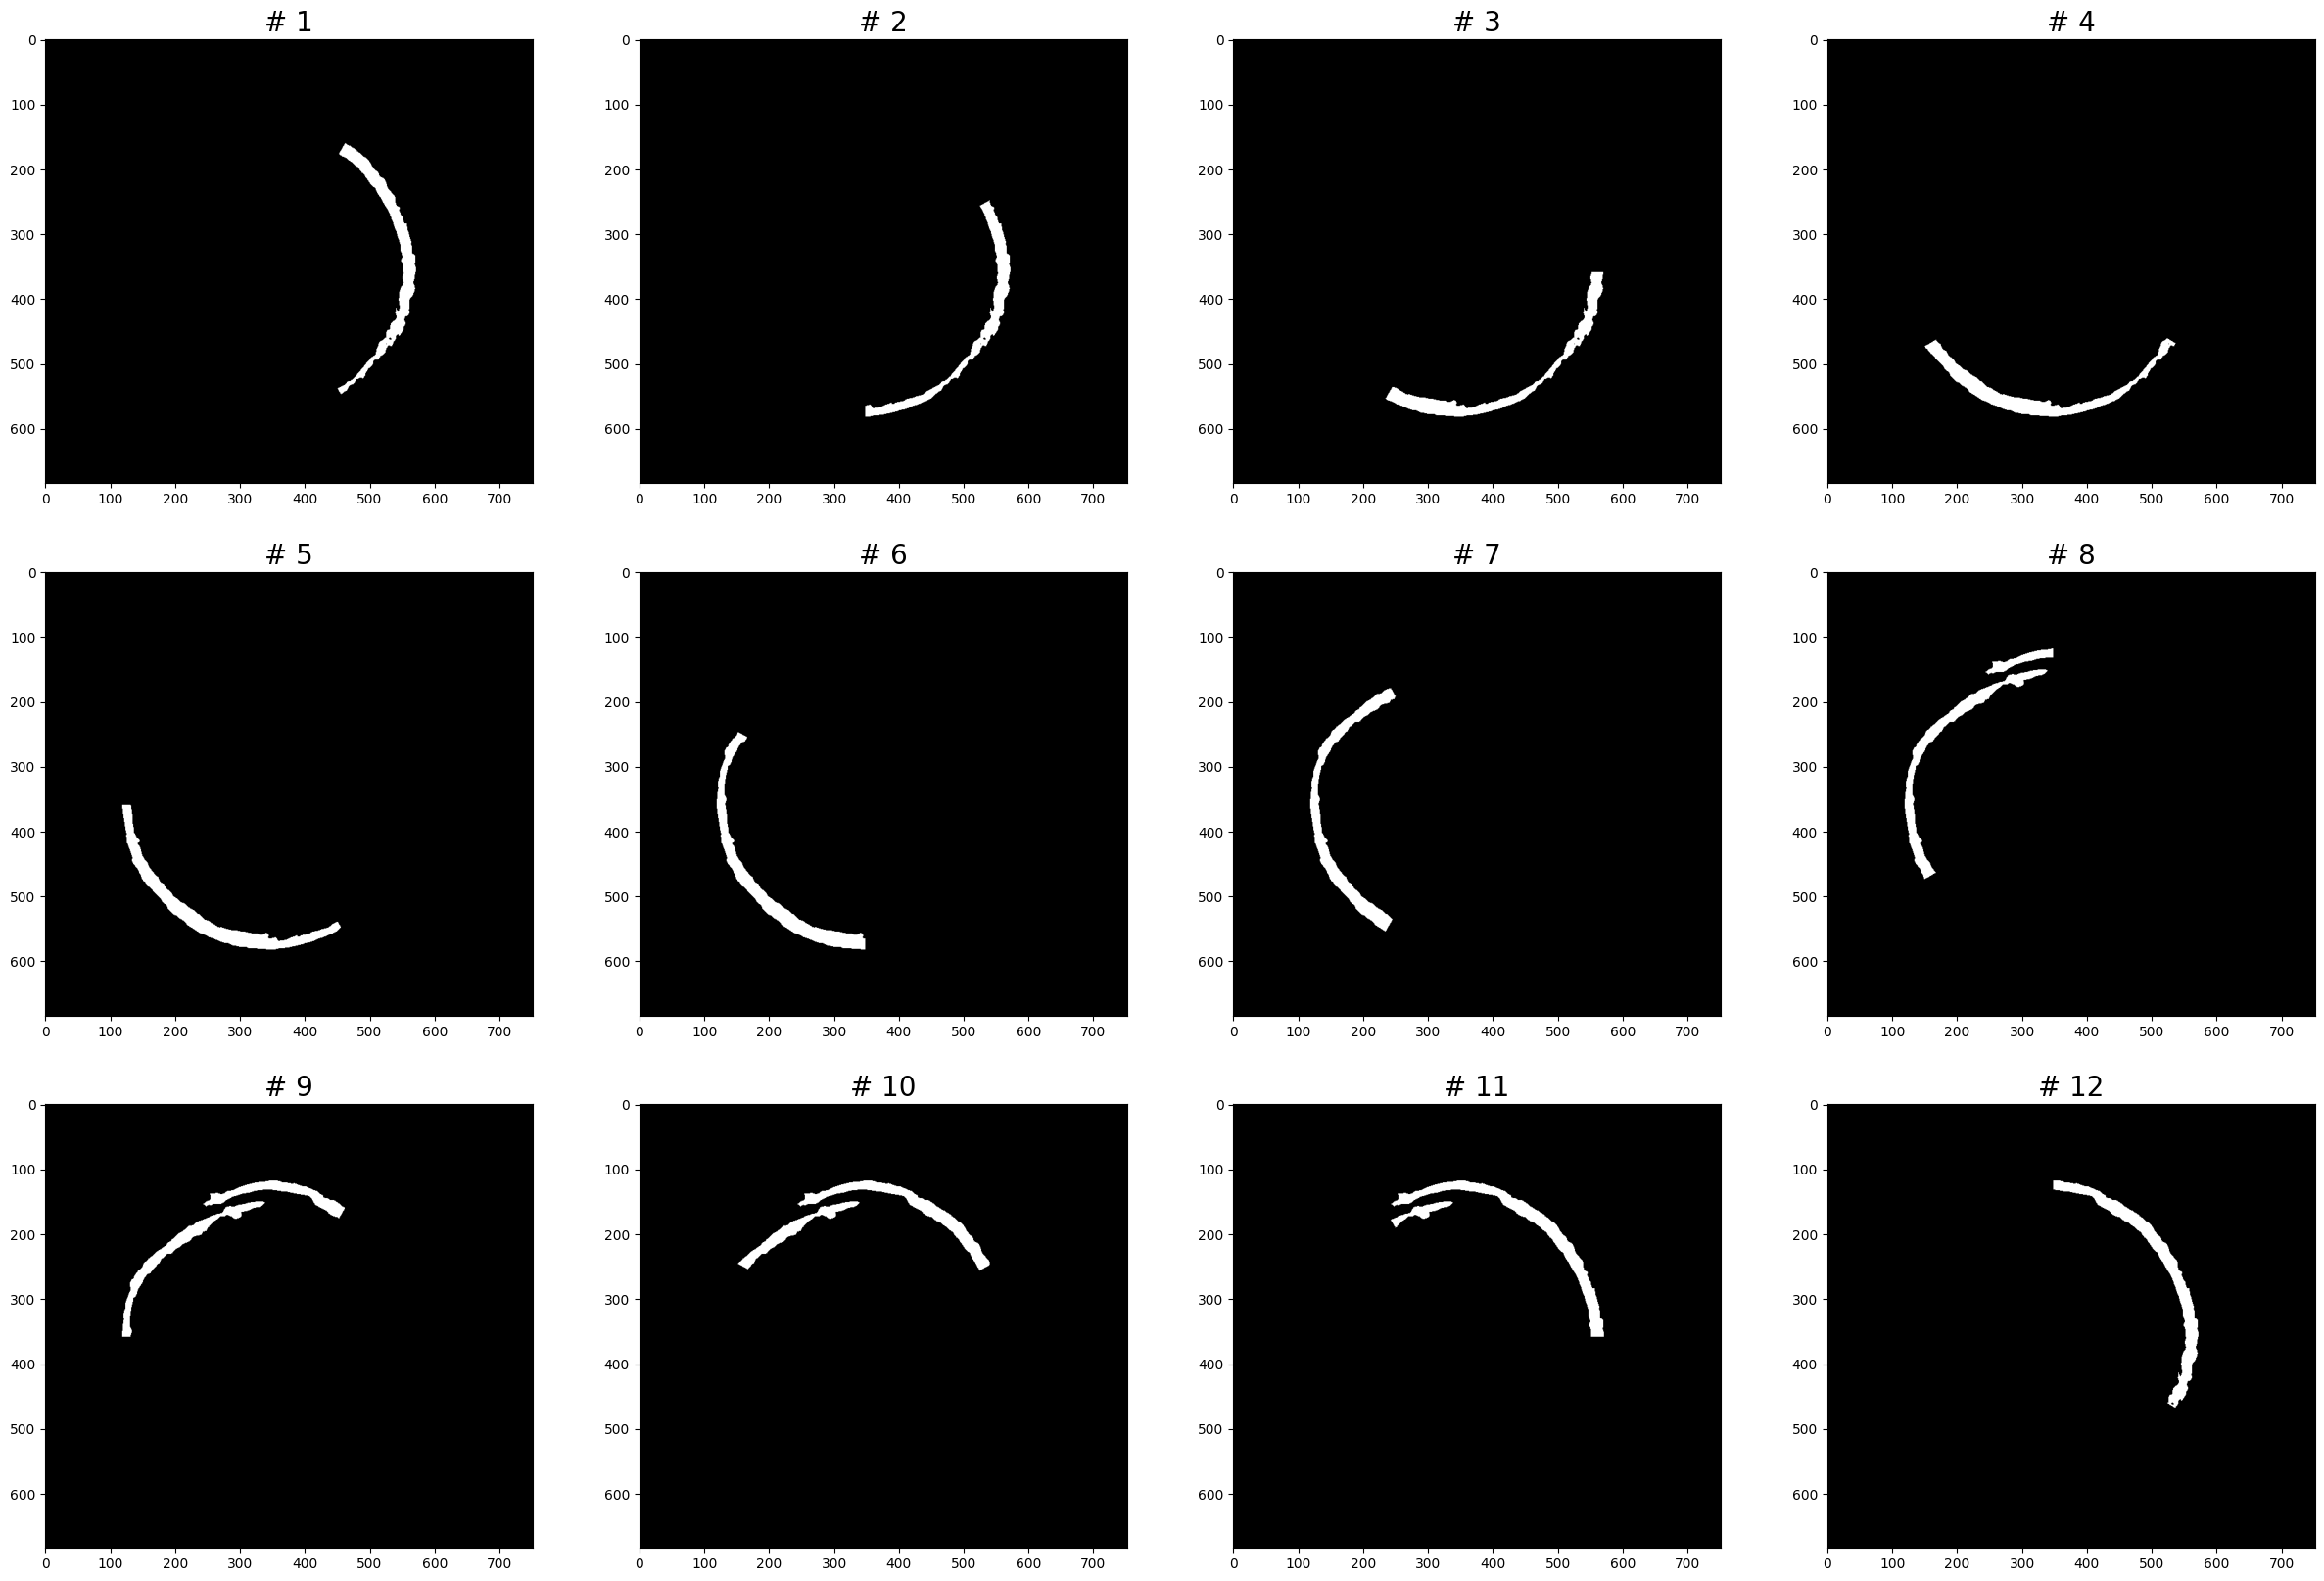

In [ ]:
@jit(nopython=True)
def create_valid_points_mask(image, cx, cy, standard_vec, angle):
    dst = np.zeros(image.shape)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y, x] == 0:
                continue
            vec = np.array([x - cx, y - cy])
            r = np.linalg.norm(vec)
            if np.dot(vec / r, standard_vec) >= np.cos(angle):
                dst[y, x] = 1
    return dst

def compute_circle_of_curvatures(image, cx, cy, partition_number, angle):
    circles = []
    for standard_angle in np.linspace(0, 2 * np.pi, partition_number + 1)[:-1]:
        standard_vec = np.array([np.cos(standard_angle), np.sin(standard_angle)])
        mask = create_valid_points_mask(image, cx, cy, standard_vec, angle)
        ys, xs = np.where(mask == 1)
        points = [(x, y) for x, y in zip(xs, ys)]
        circles.append(fit2circle_points(points))
    return circles

cx, cy, cr = list_arr_circle[index][1]
print('cx, cy, cr:', cx, cy, cr)
circles, masks = compute_circle_of_curvatures(appropriate_labels, cx, cy, 12, np.pi / 3)
plt.plot([c[2]/cr for c in circles])
plt.plot([0.9] * 12)
plt.yticks([0, 1, 2])
display_images(masks, w=4)

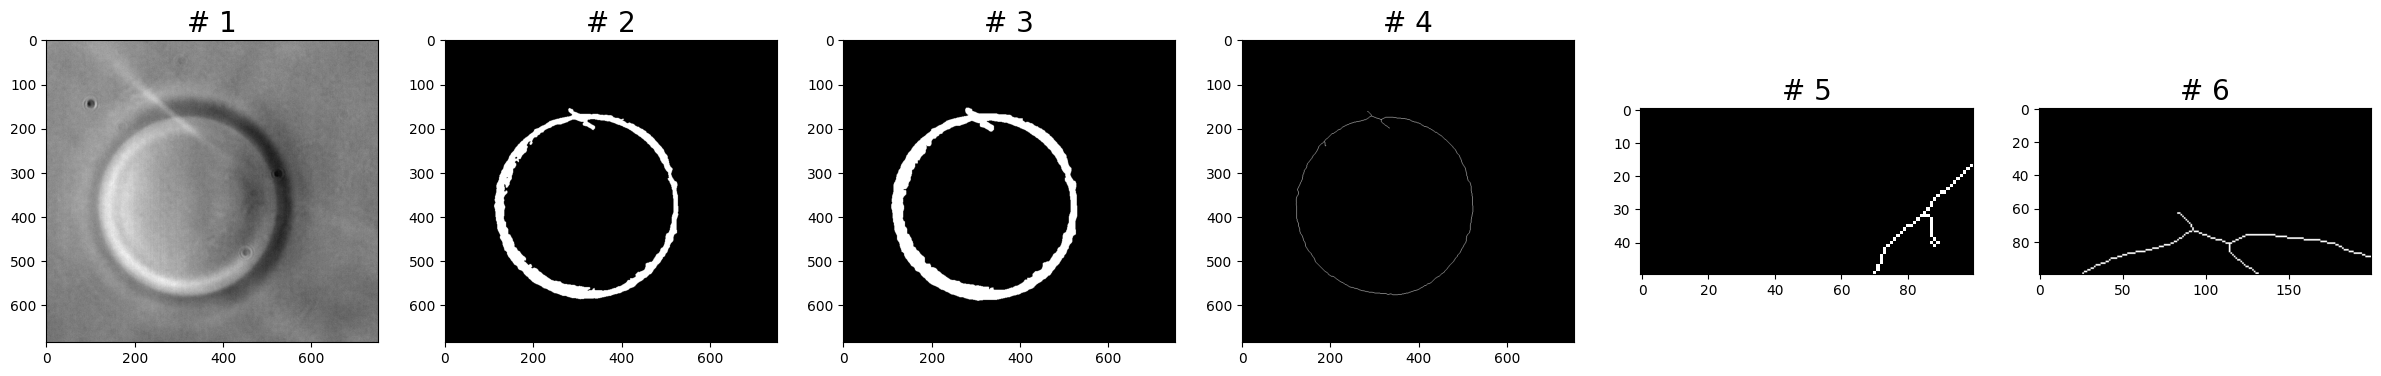

In [ ]:
# thinning
import skimage
tmp = cv2.morphologyEx(appropriate_labels, cv2.MORPH_CLOSE, (5, 5), iterations=1)

tmp = cv2.GaussianBlur(tmp, ksize=(5, 5), sigmaX=0, sigmaY=0)
tmp[tmp > 0] = 1
thinned = skimage.morphology.thin(tmp)
display_images([gray, appropriate_labels, tmp, thinned, thinned[200:250, 100:200], thinned[100:200, 200:400]])

In [127]:
# convert thinned image to an array
import copy

def get_neighbour_points(binary_image, x, y):
    dp1 = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    dp2 = [(1, 1), (1, -1), (-1, 1), (-1, -1)]
    k = np.ones((3, 3))
    k[1, 1] = 0
    res = []
    for d in dp1:
        dx, dy = d
        nx, ny = x + dx, y + dy
        if binary_image[ny, nx] == 1:
            k[1 + dy, 1 + dx] = 0
            res.append((nx, ny))
    for d in dp2:
        dx, dy = d
        nx, ny = x + dx, y + dy
        if binary_image[ny, nx] == 1 and k[1 + dy, 1 + dx] == 1:
            res.append((nx, ny))
    return res

def box_area_sum(binary_image, x, y, k):
    r = k // 2
    x1, y1 = max(0, x - r), max(0, y - r)
    x2, y2 = min(binary_image.shape[1], x + r + 1), min(binary_image.shape[0], y + r + 1)
    return np.sum(binary_image[y1:y2, x1:x2])

def isolated(binary_image, x, y):
    return box_area_sum(binary_image, x, y, 5) == box_area_sum(binary_image, x, y, 3)

def get_end_points(binary_image):
    res = []
    for y in range(binary_image.shape[0]):
        for x in range(binary_image.shape[1]):
            cnt = 0
            if binary_image[y, x] == 1:
                ds = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]
                for d in ds:
                    dx, dy = d
                    nx, ny = x + dx, y + dy
                    if binary_image[ny, nx] == 1:
                        cnt += 1
            if cnt == 1 and not isolated(binary_image, x, y):
                res.append((x, y))
    return res

def get_points_and_neighbours(binary_image):
    points_data = {}
    for y in range(binary_image.shape[0]):
        for x in range(binary_image.shape[1]):
            if binary_image[y, x] == 1:
                neighbour_points = get_neighbour_points(binary_image, x, y)
                points_data[(x, y)] = neighbour_points
    return points_data

def cut_short_branches_of_an_image(image, points_data, end_points, thresh_length=50):
    dst = np.copy(image)
    for i, end_point in enumerate(end_points):
        arr = []
        current_point = copy.copy(end_point)
        has_many_branches = False
        while(1):
            neighbour_points = points_data[current_point]
            if len(neighbour_points) > 2:
                has_many_branches = True
                break
            arr.append(current_point)
            finnished = True
            for neighbour_point in neighbour_points:
                if neighbour_point not in arr:
                    current_point = neighbour_point
                    finnished = False
            if finnished:
                break
        print(len(arr), arr[0], has_many_branches)
        if has_many_branches and len(arr) < thresh_length:
            for x, y in arr:
                dst[y, x] = 0
    return dst

def to_point_arrays(points_data, end_points):
    arrays = []
    searched_end_points = []
    for i, end_point in enumerate(end_points):
        if end_point in searched_end_points:
            continue
        arr = []
        current_point = copy.copy(end_point)
        while(1):
            arr.append(current_point)
            neighbour_points = points_data[current_point]

            finnished = True
            for neighbour_point in neighbour_points:
                if (neighbour_point not in arr) and (len(points_data[neighbour_point]) > 0):
                    current_point = neighbour_point
                    finnished = False
                    break
            if finnished:
                break
        
        searched_end_points.append(arr[0])
        searched_end_points.append(arr[-1])
        arrays.append(arr)
    return arrays

def convert_array_to_image(binary_image, arr):
    dst = np.zeros(binary_image.shape)
    for x, y in arr:
        dst[y, x] = 1
    return dst

end_points = get_end_points(thinned)
print(end_points)
points_data = get_points_and_neighbours(thinned)
new_image = cut_short_branches_of_an_image(thinned, points_data, end_points)

valid_end_points = get_end_points(new_image)
valid_points_data = get_points_and_neighbours(new_image)
arrays = to_point_arrays(valid_points_data, valid_end_points)

[(283, 163), (332, 201)]
11 (283, 163) True
23 (332, 201) True


In [128]:
len(arrays)

0

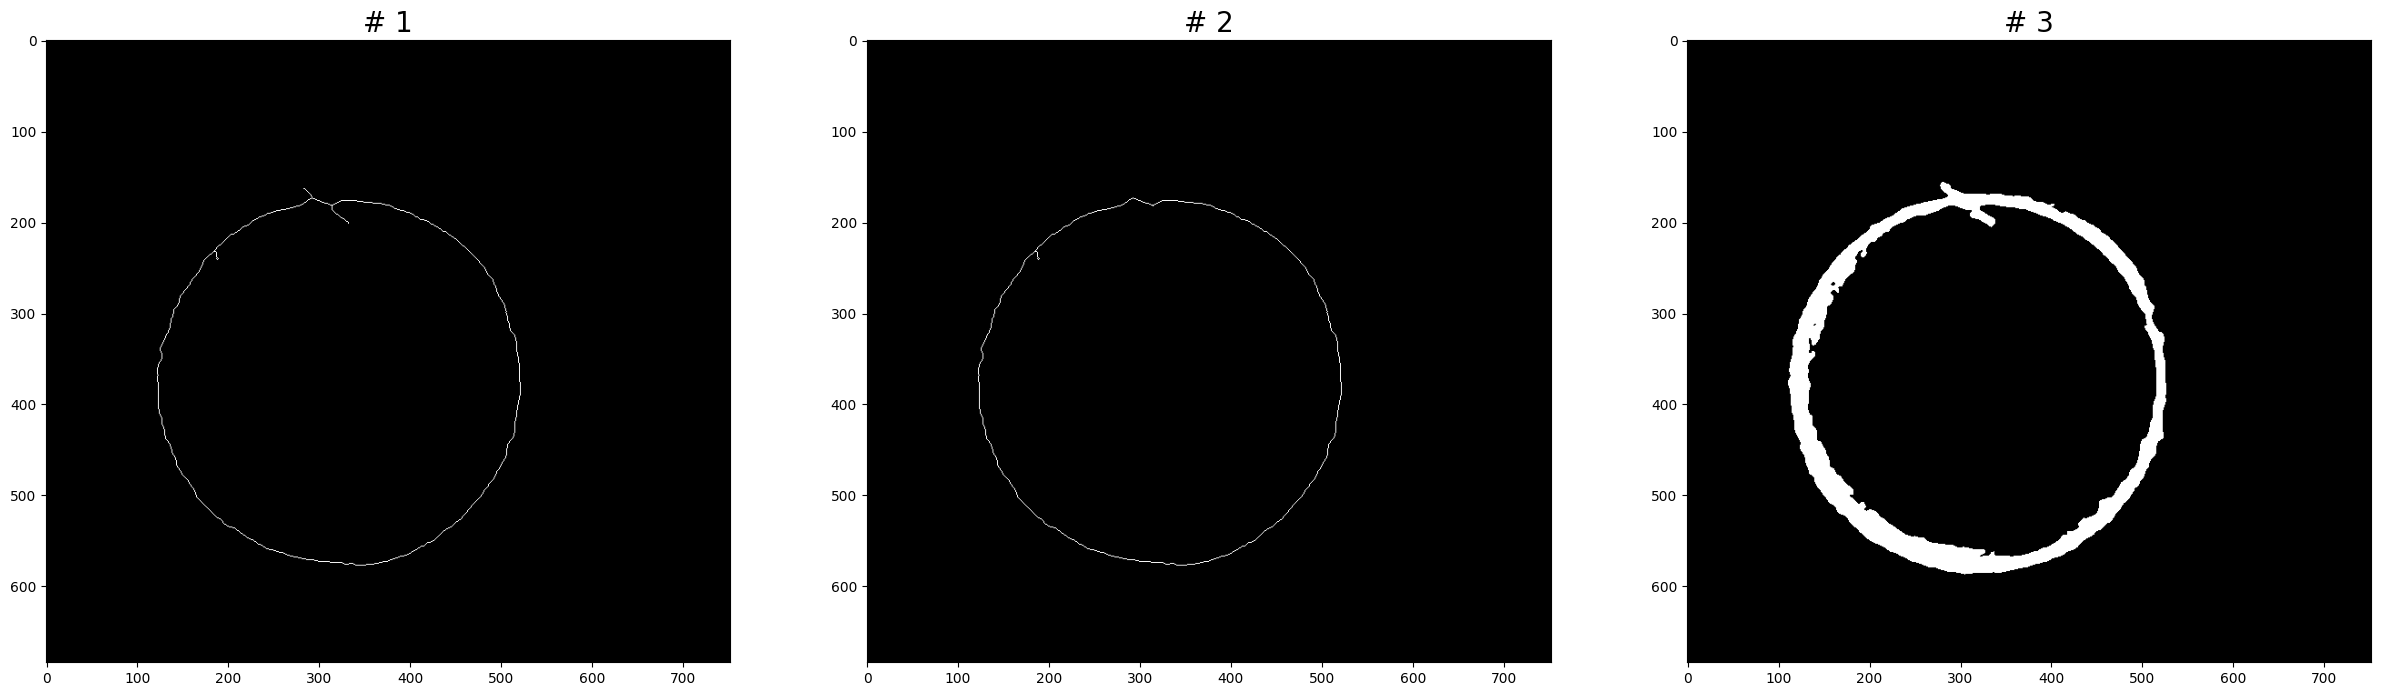

In [129]:
merged = np.copy(appropriate_labels)
for i, arr in enumerate(arrays):
    merged += convert_array_to_image(appropriate_labels, arr) * (3 * i + 3)

display_images([thinned, new_image, merged])

### 曲率を計算

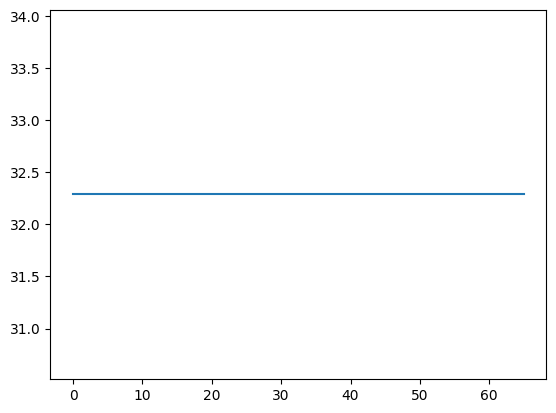

In [122]:
# i = 26
arr = arrays[0]
k = 100
plt.plot([fit2circle_points(arr[max(0, i - k):min(len(arr), i + k)])[2] for i in range(len(arr))])

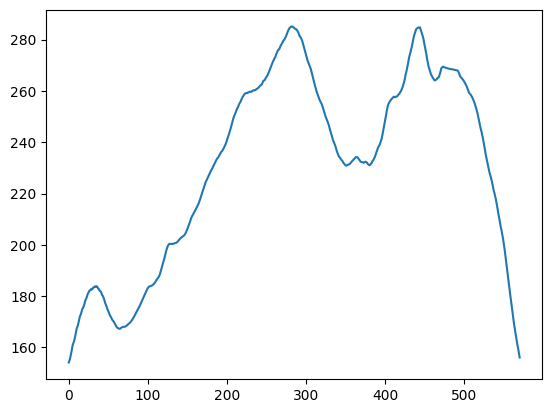

In [ ]:
# i = 33
arr = arrays[0]
k = 100
plt.plot([fit2circle_points(arr[max(0, i - k):min(len(arr), i + k)])[2] for i in range(len(arr))])

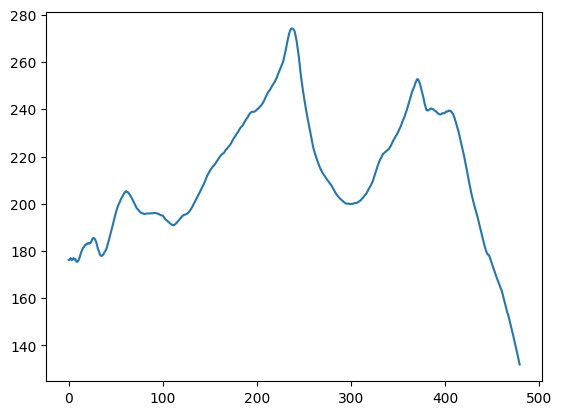

In [ ]:
# i = 41
arr = arrays[0]
k = 100
plt.plot([fit2circle_points(arr[max(0, i - k):min(len(arr), i + k)])[2] for i in range(len(arr))])
    